In [7]:
import requests
import gzip
import io
from Bio import SeqIO
from Bio import AlignIO
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
# -----------------------------
# Step 1: Download Pfam-A.seed.gz
# -----------------------------
url = "https://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.seed.gz"
response = requests.get(url, stream=True)
response.raise_for_status()

pfam_ids = ["PF00069", "PF00072"]  # Protein kinase + GPCR example
records_by_family = {pfam: [] for pfam in pfam_ids}

In [9]:
# -----------------------------
# Step 2: Parse manually, track #=GF AC
# -----------------------------
current_acc = None
block_lines = []

def process_block(block_lines, current_acc):
    """Convert collected lines into an alignment and store if matches PFAM IDs"""
    if not block_lines or current_acc not in records_by_family:
        return
    # Add missing Stockholm header and footer
    block_text = "# STOCKHOLM 1.0\n" + "".join(block_lines) + "//\n"
    handle = io.StringIO(block_text)
    alignment = AlignIO.read(handle, "stockholm")
    records_by_family[current_acc].extend(alignment)

with gzip.open(io.BytesIO(response.content), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            # Process previous block
            process_block(block_lines, current_acc)
            block_lines = [line]
            current_acc = line.split()[2].split(".")[0]  # strip version
        elif line.strip() == "//":  # end of block
            block_lines.append(line)
            process_block(block_lines, current_acc)
            block_lines = []
            current_acc = None
        else:
            block_lines.append(line)

for pfam, seqs in records_by_family.items():
    print(f"{pfam}: {len(seqs)} sequences")


PF00069: 38 sequences
PF00072: 52 sequences


In [20]:
# -----------------------------
# Step 3: Convert sequences to amino acid composition vectors
# -----------------------------
aa_list = list("ACDEFGHIKLMNPQRSTVWY")

def seq_to_composition(seq):
    counts = Counter(str(seq))
    return [counts.get(aa, 0) / len(seq) for aa in aa_list]

all_data = []
all_labels = []

for pfam, seqs in records_by_family.items():
    for record in seqs:
        comp = seq_to_composition(record.seq)
        all_data.append(comp)
        all_labels.append(pfam)

df = pd.DataFrame(all_data, columns=aa_list)
df["family"] = all_labels
print(df.head())

          A         C         D         E         F         G         H  \
0  0.021480  0.009547  0.045346  0.033413  0.011933  0.026253  0.019093   
1  0.031026  0.009547  0.023866  0.050119  0.031026  0.047733  0.007160   
2  0.014320  0.009547  0.033413  0.033413  0.016706  0.045346  0.021480   
3  0.021480  0.016706  0.031026  0.031026  0.021480  0.050119  0.019093   
4  0.052506  0.009547  0.033413  0.038186  0.021480  0.045346  0.014320   

          I         K         L  ...         N         P         Q         R  \
0  0.066826  0.064439  0.052506  ...  0.033413  0.031026  0.038186  0.014320   
1  0.054893  0.045346  0.059666  ...  0.033413  0.028640  0.021480  0.028640   
2  0.076372  0.052506  0.062053  ...  0.045346  0.023866  0.021480  0.028640   
3  0.052506  0.028640  0.071599  ...  0.023866  0.031026  0.019093  0.031026   
4  0.052506  0.033413  0.066826  ...  0.028640  0.038186  0.011933  0.033413   

          S         T         V         W         Y   family  
0  0.

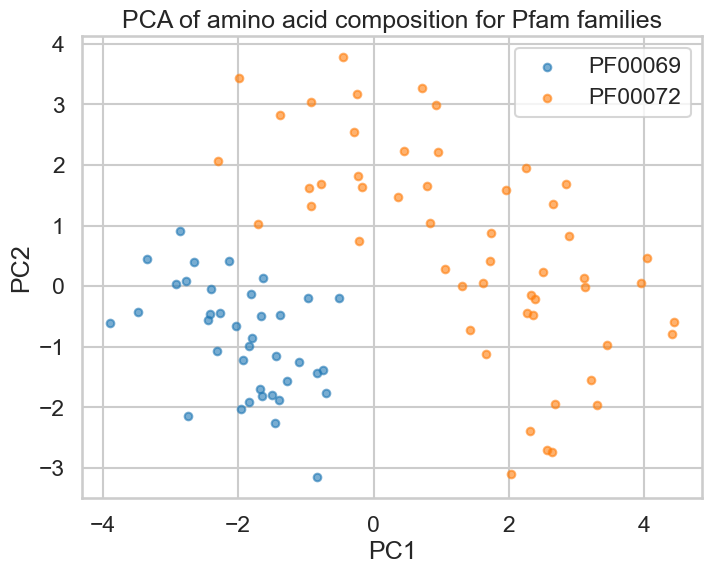

In [21]:
# -----------------------------
# Step 4: PCA visualization
# -----------------------------
if not df.empty:
    X = StandardScaler().fit_transform(df[aa_list])
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    for fam in pfam_ids:
        mask = df["family"] == fam
        plt.scatter(pcs[mask,0], pcs[mask,1], label=fam, alpha=0.6, s=30)

    plt.title("PCA of amino acid composition for Pfam families")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()
else:
    print("No sequences found for the selected Pfam IDs.")

/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


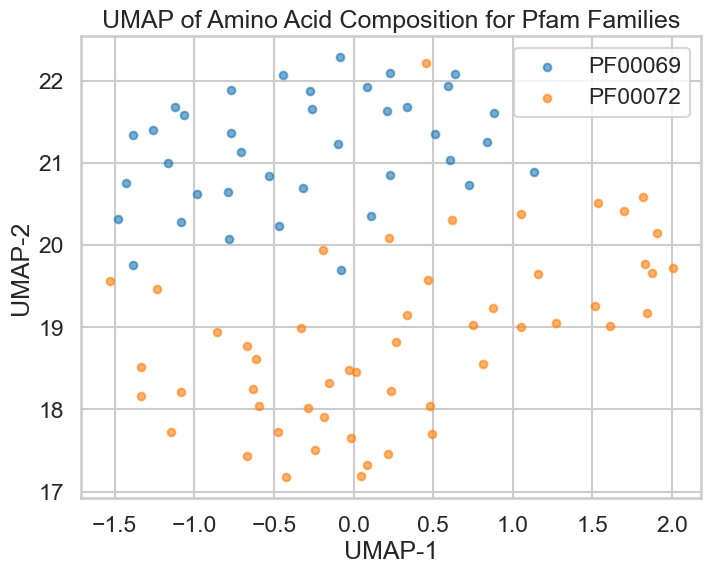

In [22]:
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap   # UMAP implementation

if not df.empty:
    # Standardize
    X = StandardScaler().fit_transform(df[aa_list])

    # UMAP instead of PCA
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    # Plot
    plt.figure(figsize=(8,6))
    for fam in pfam_ids:
        mask = df["family"] == fam
        plt.scatter(embedding[mask,0], embedding[mask,1], label=fam, alpha=0.6, s=30)

    plt.title("UMAP of Amino Acid Composition for Pfam Families")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.show()
else:
    print("No sequences found for the selected Pfam IDs.")


/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nikhilkunapareddy/Documents/masters/capstone/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


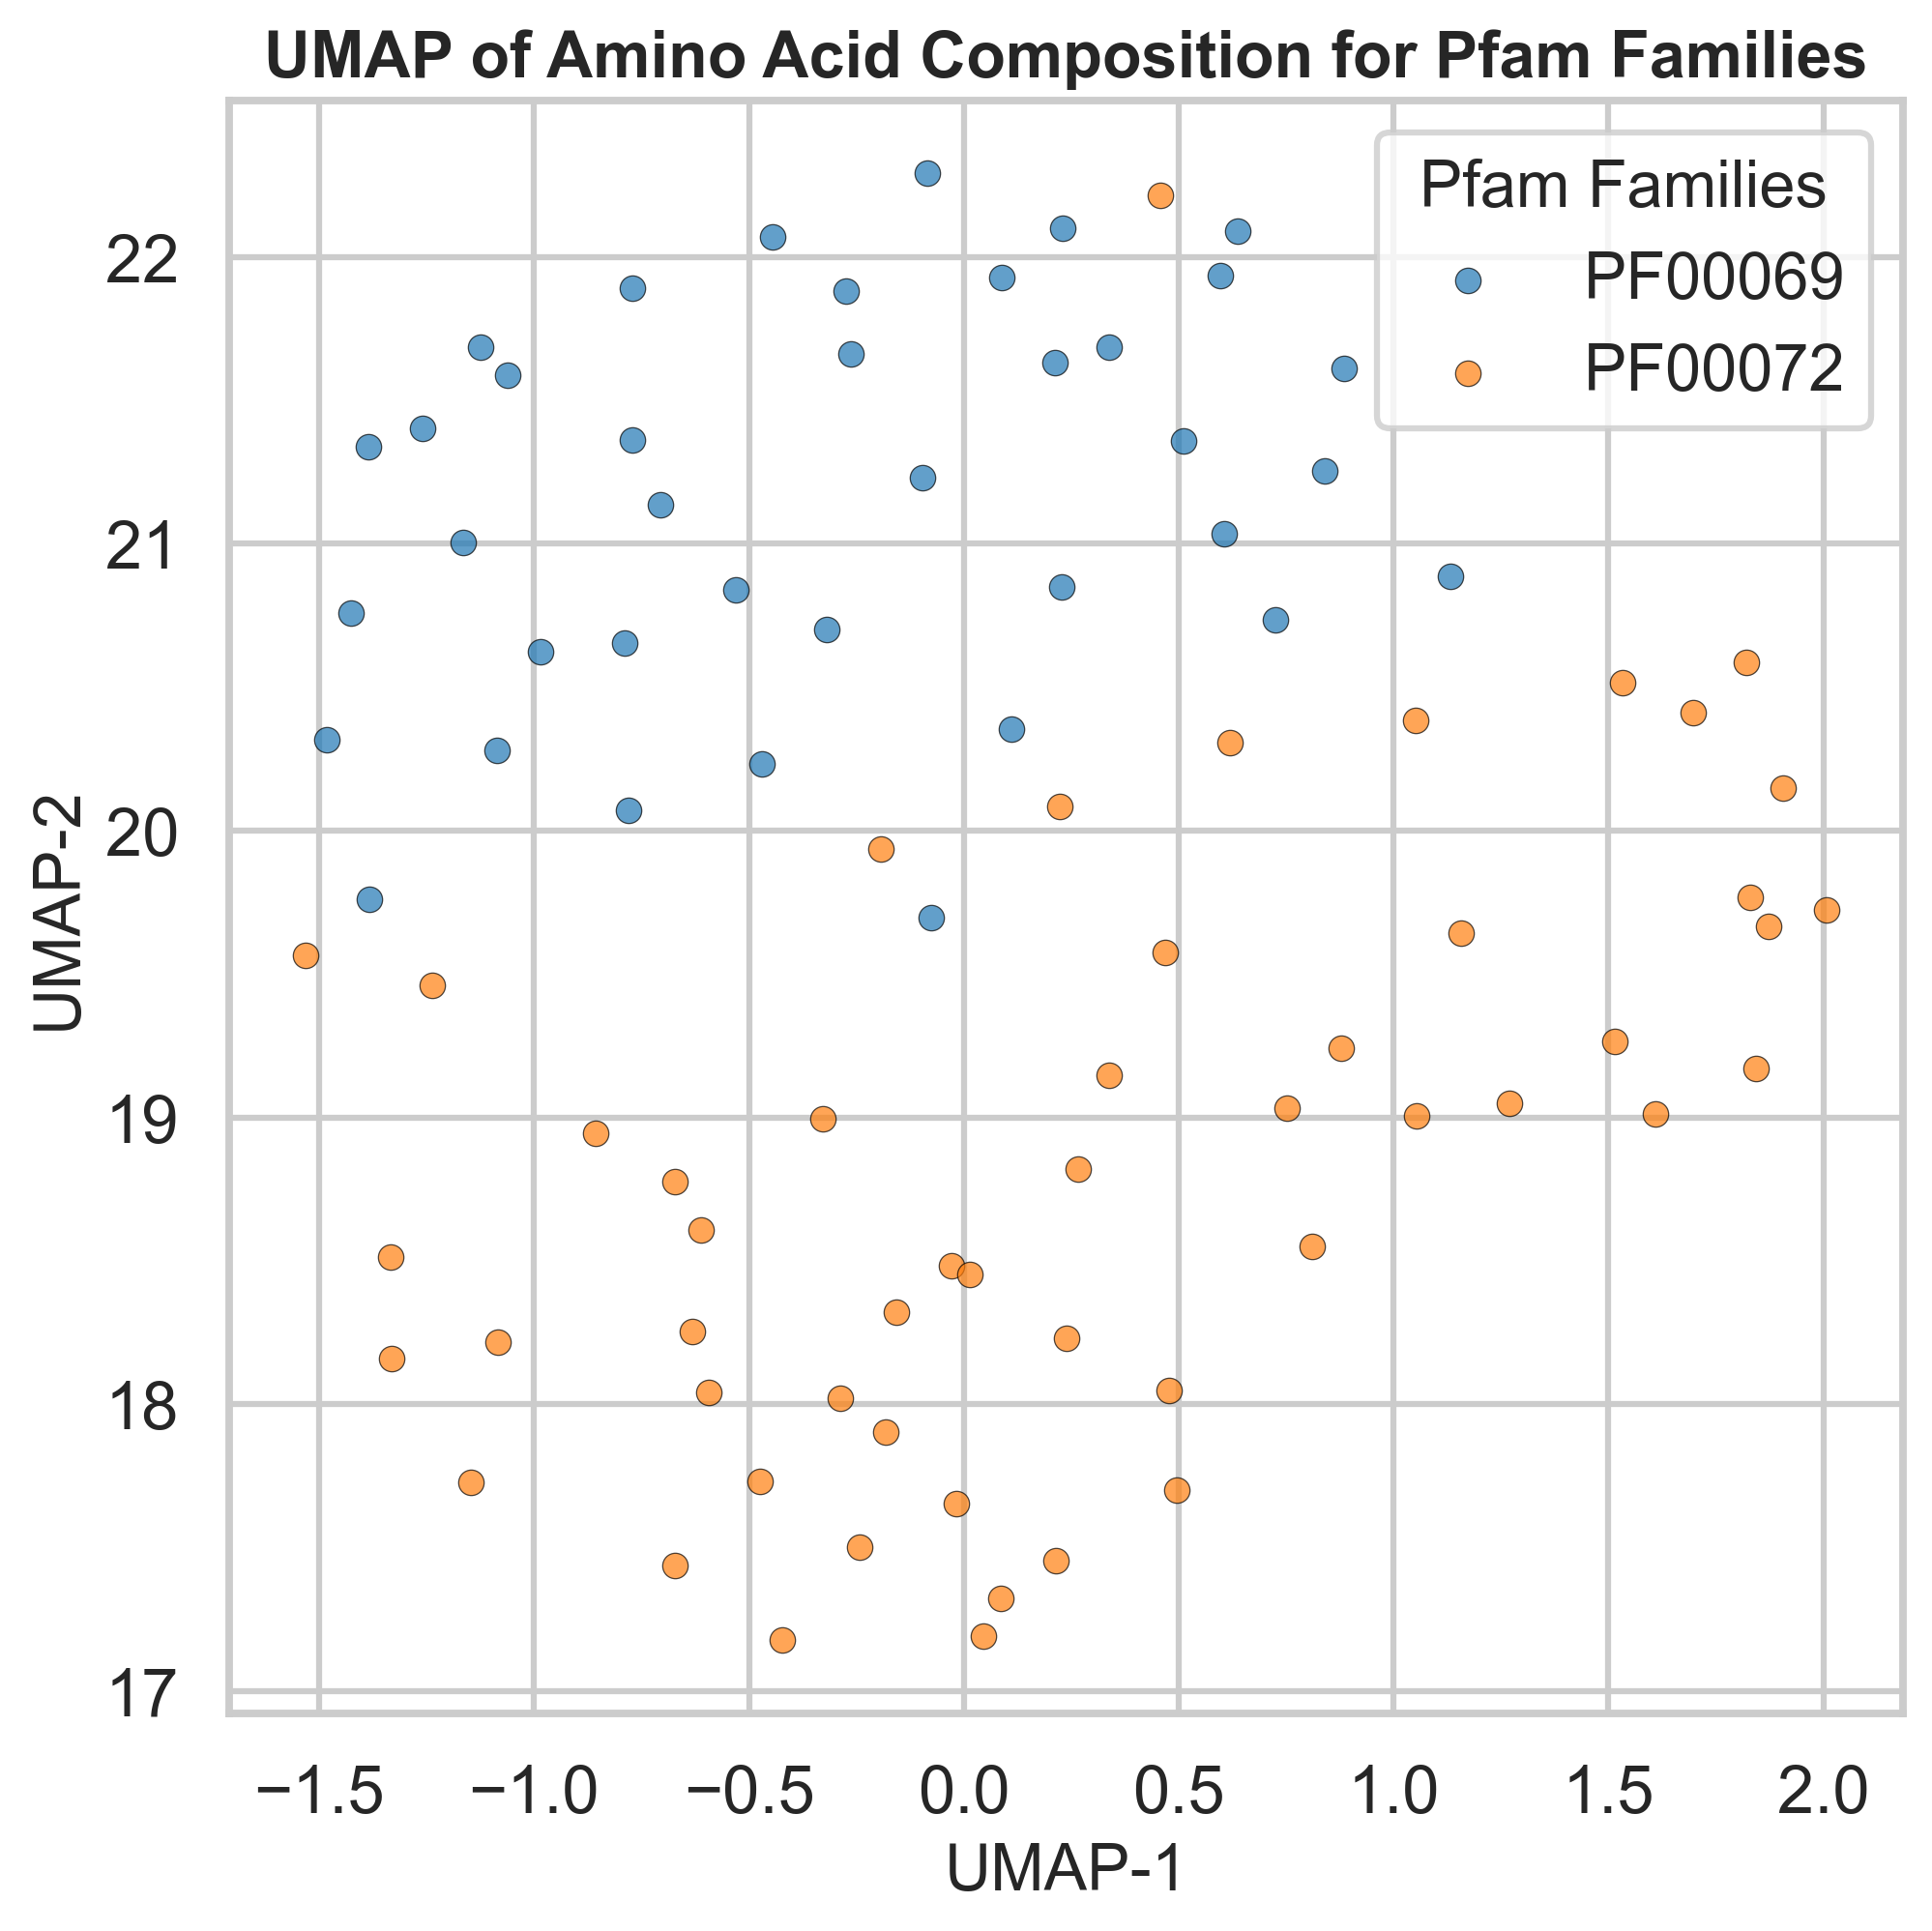

In [29]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import seaborn as sns

# Use a clean style
sns.set_context("talk")
sns.set_style("whitegrid")

if not df.empty:
    # Standardize features
    X = StandardScaler().fit_transform(df[aa_list])

    # UMAP projection
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    # Color palette
    palette = sns.color_palette("tab10", n_colors=len(pfam_ids))

    plt.figure(figsize=(7,7), dpi=300)
    for fam, color in zip(pfam_ids, palette):
        mask = df["family"] == fam
        plt.scatter(
            embedding[mask,0],
            embedding[mask,1],
            label=fam,
            alpha=0.7,
            s=40,
            edgecolor="k",
            linewidth=0.3,
            color=color
        )

    # Titles and labels
    plt.title("UMAP of Amino Acid Composition for Pfam Families", fontsize=16, weight="bold")
    plt.xlabel("UMAP-1", fontsize=16)
    plt.ylabel("UMAP-2", fontsize=16)

    # Legend inside plot
    plt.legend(
        title="Pfam Families",
        loc="best",   # automatically finds a less crowded spot
        fontsize=16,
        title_fontsize=16,
        frameon=True,
        fancybox=True,
        framealpha=0.8
    )

    plt.tight_layout()
    plt.show()
else:
    print("No sequences found for the selected Pfam IDs.")
